In [1]:
import numpy as np
import matplotlib.pyplot as plt
from looptools.loop import LOOP
from looptools.component import Component
from looptools.components import LPFComponent, TwoStageLPFComponent

In [2]:
sps = 80e6 # Loop update frequency
frfr = np.logspace(np.log10(1e2), np.log10(40e6), int(1e5)) # Fourier frequency array (Hz)

# Define components
lpf1 = LPFComponent("Low Pass Filter #1", sps, 5)
lpf2 = LPFComponent("Low Pass Filter #2", sps, 5)
lpf2stage = TwoStageLPFComponent("2-Stage Low Pass Filter", sps, 5)

# Build loops
loop1 = LOOP(sps, [lpf1, lpf2])
loop2 = LOOP(sps, [lpf2stage])

In [ ]:
def loop_bode_plot(frfr, loop, loop2=None):
    figsize=(6,4)
    dpi=300
    fontsize=8
    linewidth=2

    fig, (ax1, ax2) = plt.subplots(2,1, figsize=figsize, dpi=dpi)
    ax1.loglog(frfr, np.abs(loop.Gf(f=frfr)), linewidth=linewidth, color="royalblue", label="Open-loop transfer function")
    ax2.semilogx(frfr, np.angle(loop.Gf(f=frfr), deg=True), linewidth=linewidth, color="royalblue")
    ax1.loglog(frfr, np.abs(loop.Hf(f=frfr)), linewidth=linewidth, color="lime", label="System function", ls='-')
    ax2.semilogx(frfr, np.angle(loop.Hf(f=frfr), deg=True), linewidth=linewidth, color="lime", ls='-')
    ax1.loglog(frfr, np.abs(loop.Ef(f=frfr)), linewidth=linewidth, color="tomato", label="Error function", ls='-')
    ax2.semilogx(frfr, np.angle(loop.Ef(f=frfr), deg=True), linewidth=linewidth, color="tomato", ls='-')
    if loop2 is not None:
        ax1.loglog(frfr, np.abs(loop2.Gf(f=frfr)), linewidth=1.0, color="black", ls='--')
        ax2.semilogx(frfr, np.angle(loop2.Gf(f=frfr), deg=True), linewidth=1.0, color="black", ls='--')
        ax1.loglog(frfr, np.abs(loop2.Hf(f=frfr)), linewidth=1.0, color="black", ls='--')
        ax2.semilogx(frfr, np.angle(loop2.Hf(f=frfr), deg=True), linewidth=1.0, color="black", ls='--')
        ax1.loglog(frfr, np.abs(loop2.Ef(f=frfr)), linewidth=1.0, color="black", ls='--')
        ax2.semilogx(frfr, np.angle(loop2.Ef(f=frfr), deg=True), linewidth=1.0, color="black", ls='--')
    ax2.set_xlabel("Frequency (Hz)", fontsize=fontsize)
    ax1.set_ylabel("Magnitude", fontsize=fontsize)
    ax2.set_ylabel("Phase (deg)", fontsize=fontsize)
    ax1.axes.xaxis.set_ticklabels([])
    ax1.tick_params(labelsize=fontsize)
    ax2.tick_params(labelsize=fontsize)
    ax1.grid()
    ax2.grid()
    ax1.set_xlim(frfr[0],frfr[-1])
    ax2.set_xlim(frfr[0],frfr[-1])
    ax1.legend(loc='best', edgecolor='black', fancybox=True, shadow=True, framealpha=1, fontsize=fontsize-3, handlelength=2.9)
    fig.tight_layout()
    fig.align_ylabels()

    return fig

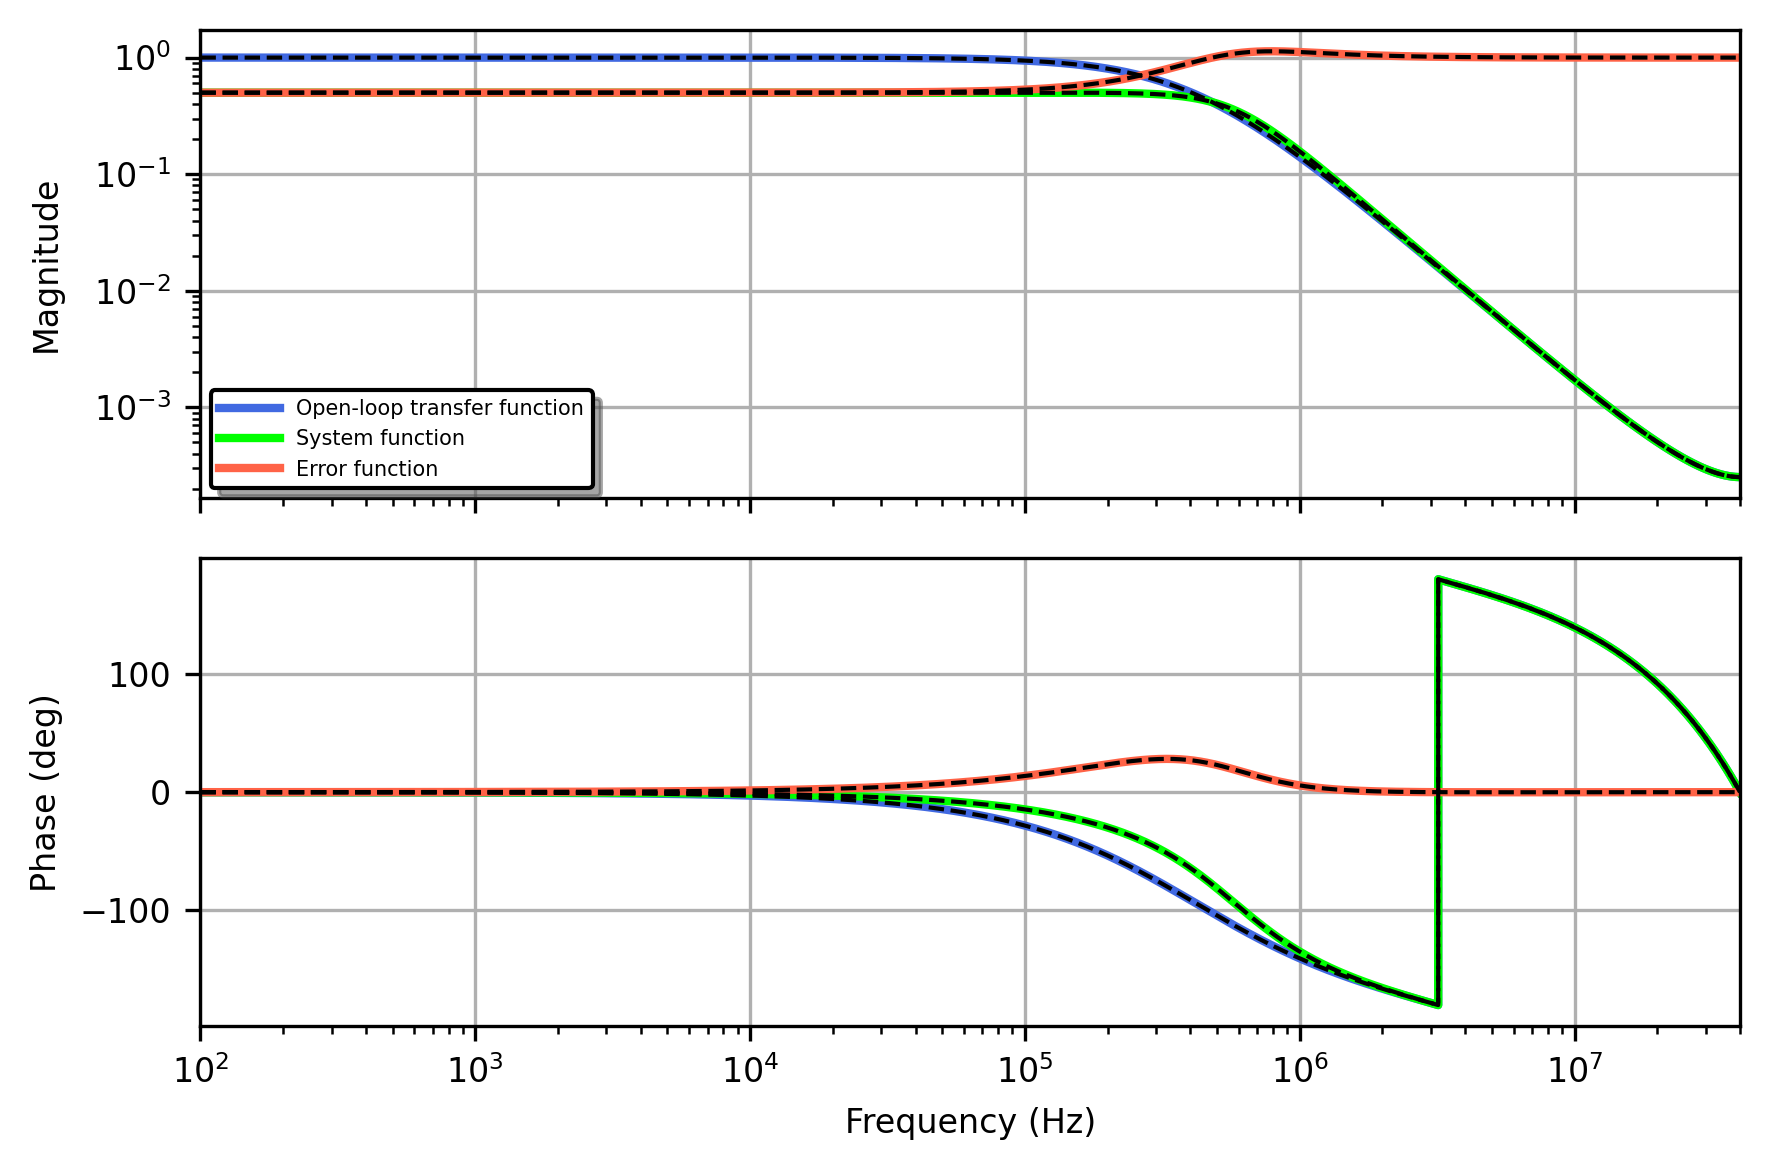

In [4]:
fig = loop_bode_plot(frfr, loop1, loop2)